In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt


Read in data to generate Pandas dataframe. If generating for the first time, will take about five minutes. Otherwise, it should take about 10 seconds.

In [2]:
datapath = '../data/Pose_Dataset/'
nFrames = 300 # number of frames per squat
df_filename = '../data/all-data.pkl' # where to save concatenated data
np_filename = '../data/np-data.npy'
name_to_label = {
    'bad_inner_thigh': 0,
    'bad_back_round': 1,
    'bad_back_warp': 2,
    'bad_head': 3,
    'bad_shallow': 4,
    'bad_toe': 5,
    'good': 6
}

if os.path.exists(df_filename) and os.path.exists(np_filename):
    # read in pkl file
    df = pd.read_pickle(df_filename)
    with open(np_filename, 'rb') as f:
        X_train = np.load(f)
        y_train = np.load(f)
        X_val = np.load(f)
        y_val = np.load(f)
        X_test = np.load(f)
        y_test = np.load(f)
else:
    # generate pkl file and npy file

    # initialize arrays to fill in each loop iteration
    filenames = []
    datas = []
    np_datas = []
    labels = []

    # read in each squat file
    for cur_dir, _, files in os.walk(datapath):
        for file in files:
            if not file.endswith('.json'):
                continue
            filename = os.path.join(cur_dir, file)
            filenames.append(filename)

            data = pd.read_json(filename).to_numpy()
            data = data[1,0:nFrames] # get data for frames. Note some files have 301 frames, truncate all to first 300
            datas.append(data)
            np_data = np.array([np.array(d) for d in data])
            if np_data.shape == (300, 171):
                np_datas.append(np_data)
            labels.append(name_to_label[cur_dir.split('/')[-2]])
        print(f"Done processing {cur_dir}")

    # move arrays into dataframe
    datas = np.array(datas) # convert to array so we can loop through
    d = {'filename': filenames}
    for i in range(nFrames):
        d[str(i)] = datas[:,i]
    df = pd.DataFrame(data=d)

    # save to pkl
    df.to_pickle(df_filename)

    # write data into numpy arrays and save
    np_datas = np.stack(np_datas)
    labels = np.array(labels)

    n = np_datas.shape[0]
    split_indices = [int(n * 0.8), int(n * 0.9)]
    train_indices, val_indices, test_indices = np.split(np.random.choice(n, n, replace=False), split_indices)

    X_train = np_datas[train_indices]
    y_train = labels[train_indices]

    X_val = np_datas[val_indices]
    y_val = labels[val_indices]

    X_test = np_datas[test_indices]
    y_test = labels[test_indices]
    
    with open(np_filename, 'wb') as f:
        np.save(f, X_train)
        np.save(f, y_train)
        np.save(f, X_val)
        np.save(f, y_val)
        np.save(f, X_test)
        np.save(f, y_test)

Add label column based on filename

In [3]:
df['label'] = [df['filename'][i].split('/')[3] for i in range(len(df))]

Print out the first five rows of the dataframe. The 'filename' column contains full filepath + name of each squat, and the remaining columns contain pose data for each of 300 frames.

In [4]:
df.head(5)

,filename,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,label
0,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.43120177353718403, 0.797377414334803, 0.844...","[0.430941564889928, 0.79869170732256, 0.847091...","[0.431044555308539, 0.799997781067416, 0.84760...","[0.431592316178638, 0.7988144430510611, 0.8469...","[0.4311132590348, 0.7942079960716251, 0.840107...","[0.43193753462167306, 0.7949407220012981, 0.84...","[0.432750845147567, 0.7839057041264701, 0.8325...","[0.432541413484046, 0.787418809894588, 0.83614...","[0.431894497467298, 0.786059366307652, 0.83555...",...,"[0.43357581090852304, 0.7943466004531391, 0.84...","[0.433069769111656, 0.7938311318961081, 0.8431...","[0.431030331629899, 0.786474443905499, 0.83585...","[0.43115121328079503, 0.7842615868752231, 0.83...","[0.43390441871996305, 0.7924671389584511, 0.84...","[0.43198091643781905, 0.7867065528136351, 0.83...","[0.43174849778878904, 0.783046079262931, 0.836...","[0.43123957336803503, 0.787923224200576, 0.840...","[0.428997741451614, 0.780915252148985, 0.83353...",good
1,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.47551463277682005, 0.9215836428119221, 0.93...","[0.47563254721491705, 0.9217684412264681, 0.93...","[0.47606479372639904, 0.921504059759201, 0.932...","[0.476369782218, 0.920659233360356, 0.93398515...","[0.474865629960791, 0.9185499246891451, 0.9351...","[0.47621913132710003, 0.9194576930028691, 0.93...","[0.47541189727106403, 0.916291807802979, 0.935...","[0.473958178841594, 0.9117857030781501, 0.9319...","[0.47338005686455703, 0.907825476525932, 0.933...",...,"[0.43516232461652304, 0.7482315863841671, 0.81...","[0.440398428175206, 0.771004741367683, 0.83682...","[0.45157124879577604, 0.815575642811675, 0.875...","[0.456352779376737, 0.843149297107819, 0.90124...","[0.464314572629178, 0.8598558365912851, 0.9082...","[0.46697763869442105, 0.8769539497506571, 0.92...","[0.46801772225950805, 0.8857252811475381, 0.92...","[0.468906910070493, 0.89422190287234, 0.928794...","[0.47246470516002803, 0.9024032699077711, 0.93...",good
2,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.487507568770135, 0.945001119666321, 0.95042...","[0.48724964719018404, 0.9447277868278361, 0.94...","[0.48733040533680005, 0.9444814068387251, 0.95...","[0.487969080175346, 0.946172353218329, 0.95415...","[0.48801193176894003, 0.946446475083851, 0.954...","[0.48742002510173404, 0.9443007012276421, 0.95...","[0.48699883703371705, 0.944366404361722, 0.957...","[0.48672516046768005, 0.9434340433389351, 0.95...","[0.48594678261619706, 0.9419660089707981, 0.95...",...,"[0.48502701306215, 0.9386721636737401, 0.95784...","[0.48510789168053, 0.9385537482653441, 0.95760...","[0.48517004926523405, 0.9378531640723361, 0.95...","[0.485991932994121, 0.9392084318376931, 0.9576...","[0.48617870299984006, 0.9400844966051861, 0.95...","[0.48613420586339506, 0.939901991724413, 0.950...","[0.48738268976887006, 0.9421225640340241, 0.95...","[0.487048790933767, 0.941068299266387, 0.94779...","[0.48686638446639, 0.9400423518104981, 0.94476...",good
3,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.47153572199932403, 0.857707360049973, 0.912...","[0.47160060745792703, 0.8573000747132821, 0.91...","[0.47036495298267605, 0.8531030652053331, 0.90...","[0.47240727772132, 0.860811007425445, 0.915781...","[0.46991840338782903, 0.8573401020290371, 0.91...","[0.47183890308743204, 0.8578533481614711, 0.91...","[0.469546441113654, 0.85047357179348, 0.904737...","[0.472174902614971, 0.854945950506319, 0.91187...","[0.46757983379684404, 0.8449749239116151, 0.90...",...,"[0.39646774404282203, 0.6211367265235841, 0.68...","[0.401195957721987, 0.6348000804749631, 0.7068...","[0.40244821179802404, 0.6407111917934291, 0.71...","[0.40574182411201004, 0.6531848616857611, 0.72...","[0.40859117574242604, 0.6741368173148691, 0.74...","[0.409277574312078, 0.6778921720769541, 0.7455...","[0.409182634792002, 0.682084981652292, 0.75031...","[0.412567976505038, 0.69516563040747, 0.759781

In [5]:
labels = df.label.unique()
for label in labels:
    print('%s: %i' %(label,sum(df['label']==label)))

nClasses = 7

print('\n Train')
labels = df.label.unique()
for i in range(nClasses):
    print('%s: %i' %(i,sum(y_train==i)))

print('\n Val')
labels = df.label.unique()
for i in range(nClasses):
    print('%s: %i' %(i,sum(y_val==i)))

print('\n Test')
labels = df.label.unique()
for i in range(nClasses):
    print('%s: %i' %(i,sum(y_test==i)))

good: 293
bad_toe: 295
bad_shallow: 319
bad_innner_thigh: 230
bad_back_round: 280
bad_back_warp: 312
bad_head: 272

 Train
0: 187
1: 225
2: 254
3: 219
4: 249
5: 224
6: 242

 Val
0: 23
1: 21
2: 37
3: 22
4: 40
5: 36
6: 21

 Test
0: 20
1: 34
2: 21
3: 30
4: 30
5: 35
6: 30


In [6]:
# # TODO remove this in future
# mask = (y_train == 6) | (y_train == 1)

# X_train = X_train[mask]
# y_train = y_train[mask]
# y_train = np.where(y_train != 6, 0, 1)

# mask = (y_val == 6) | (y_val == 1)

# X_val = X_val[mask]
# y_val = y_val[mask]
# y_val = np.where(y_val != 6, 0, 1)

# # y_test = np.where(y_test != 6, 0, 1)

# print(np.sum(y_train) / np.size(y_train))
# print(y_train.shape)
print(y_train)

[3 6 2 ... 6 4 0]


In [7]:
# one-hot y values # REMEMBER TO ONLY RUN THIS ONCE
y_train_onehot = tf.keras.utils.to_categorical(y_train,num_classes=nClasses)
y_val_onehot = tf.keras.utils.to_categorical(y_val,num_classes=nClasses)
y_test_onehot = tf.keras.utils.to_categorical(y_test,num_classes=nClasses)

In [8]:
import random

model_input = tf.keras.Input(shape=(300,171))
print(model_input.shape)

# first conv layer
x = tf.keras.layers.Conv1D(256,3,strides=2,padding='same')(model_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
print(x.shape)

# res layers
nResLayers = 4

for i in range(nResLayers):
    y = tf.keras.layers.Conv1D(256,3,strides=2,padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    y = tf.keras.layers.Conv1D(256,3,strides=1,padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    y = tf.keras.layers.Conv1D(256,3,strides=1,padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    z = tf.keras.layers.Conv1D(256,1,strides=2,padding='same')(x)
    z = tf.keras.layers.BatchNormalization()(z)
    
    x = tf.keras.layers.add([y,z])
    print(x.shape)

# adaptive average pool
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Reshape((256,))(x)
# # final conv layer
# model_output = tf.keras.layers.Conv1D(2,1,strides=1)(x)
model_output = tf.keras.layers.Dense(nClasses, activation='softmax')(x)
        
model = tf.keras.Model(model_input, model_output, name="ogata_model")
model.summary()

(None, 300, 171)
(None, 150, 256)
(None, 75, 256)
(None, 38, 256)
(None, 19, 256)
(None, 10, 256)
Model: "ogata_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 171)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 150, 256)     131584      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 256)     0           batch_normalization[0][0

In [9]:
# #experimenting with different filters and with dropout to see if can reduce overfitting....this didn't really work (essentially same results as before)

# import random

# model_input = tf.keras.Input(shape=(300,171))
# print(model_input.shape)

# # adding some random choice to choose dropouts
# random_number = random.random()
# print(random_number)

# # first conv layer
# x = tf.keras.layers.Conv1D(512,3,strides=2,padding='same')(model_input)
# # x = tf.keras.layers.Dropout(.2)(x) #adding dropout to help with overfitting
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation('relu')(x)
# print(x.shape)

# # res layers
# nResLayers = 4
# drop_out = 0.06

# for i in range(nResLayers):
#     y = tf.keras.layers.Conv1D(512,3,strides=2,padding='same')(x)
#     if i == 0:
#         y = tf.keras.layers.Dropout(drop_out)(y) #adding dropout to help with overfitting 
#     y = tf.keras.layers.BatchNormalization()(y)
#     y = tf.keras.layers.Activation('relu')(y)

#     y = tf.keras.layers.Conv1D(256,3,strides=1,padding='same')(y)
#     if i == 1:
#         y = tf.keras.layers.Dropout(drop_out)(y) #adding dropout to help with overfitting
#     y = tf.keras.layers.BatchNormalization()(y)
#     y = tf.keras.layers.Activation('relu')(y)

#     y = tf.keras.layers.Conv1D(128,1,strides=1,padding='same')(y)
#     if i == 2:
#         y = tf.keras.layers.Dropout(drop_out)(y) #adding dropout to help with overfitting
#     y = tf.keras.layers.BatchNormalization()(y)
#     y = tf.keras.layers.Activation('relu')(y)

#     z = tf.keras.layers.Conv1D(128,1,strides=2,padding='same')(x)
#     if i == 3:
#         z = tf.keras.layers.Dropout(drop_out)(z) #adding dropout to help with overfitting
#     z = tf.keras.layers.BatchNormalization()(z)
    
#     x = tf.keras.layers.add([y,z])
#     print(x.shape)

# # adaptive average pool
# x = tf.keras.layers.GlobalAveragePooling1D()(x)
# x = tf.keras.layers.Reshape((128,))(x)
# # # final conv layer
# # model_output = tf.keras.layers.Conv1D(2,1,strides=1)(x)
# model_output = tf.keras.layers.Dense(nClasses, activation='softmax')(x)
        
# model = tf.keras.Model(model_input, model_output, name="ogata_model")
# model.summary()

In [10]:
BATCH_SIZE = 16
opt = tf.keras.optimizers.Adadelta(learning_rate =0.01)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
train_dset = tf.data.Dataset.from_tensor_slices((X_train,y_train_onehot)).batch(BATCH_SIZE)
val_dset = tf.data.Dataset.from_tensor_slices((X_val,y_val_onehot)).batch(BATCH_SIZE)
test_dset = tf.data.Dataset.from_tensor_slices((X_test,y_test_onehot)).batch(BATCH_SIZE)

In [11]:
history = model.fit(train_dset,epochs=30,validation_data = val_dset)

Epoch 1/30
100/100 [==============================] - 17s 174ms/step - loss: 1.8851 - accuracy: 0.2881 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 9s 94ms/step - loss: 1.3800 - accuracy: 0.5250 - val_loss: 2.3773 - val_accuracy: 0.1950
Epoch 3/30
100/100 [==============================] - 9s 93ms/step - loss: 1.1250 - accuracy: 0.6388 - val_loss: 2.4370 - val_accuracy: 0.2100
Epoch 4/30
100/100 [==============================] - 9s 93ms/step - loss: 0.9469 - accuracy: 0.7337 - val_loss: 1.9112 - val_accuracy: 0.2450
Epoch 5/30
100/100 [==============================] - 9s 92ms/step - loss: 0.8070 - accuracy: 0.7944 - val_loss: 1.4124 - val_accuracy: 0.4500
Epoch 6/30
100/100 [==============================] - 9s 93ms/step - loss: 0.6918 - accuracy: 0.8494 - val_loss: 1.2287 - val_accuracy: 0.5300
Epoch 7/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5940 - accuracy: 0.8856 - val_loss: 1.1667 - val_accura

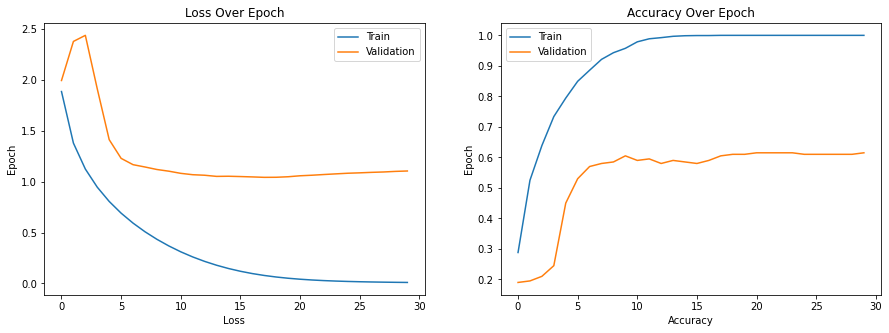

In [12]:
x = np.arange(len(history.history['accuracy']))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Loss Over Epoch")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Accuracy Over Epoch")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend()
plt.show()

plt.close()

In [13]:
# test set
(loss,accuracy) = model.evaluate(test_dset)
print('Test accuracy: %.3f' %accuracy)

13/13 [==============================] - 0s 27ms/step - loss: 0.9545 - accuracy: 0.6850
Test accuracy: 0.685


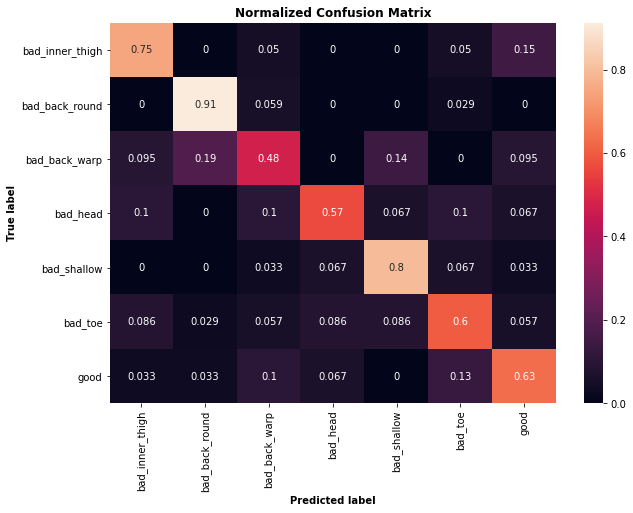


Accuracy: 0.69

Micro Precision: 0.69
Micro Recall: 0.69
Micro F1-score: 0.69

Macro Precision: 0.67
Macro Recall: 0.68
Macro F1-score: 0.67

Weighted Precision: 0.68
Weighted Recall: 0.69
Weighted F1-score: 0.68

Classification Report

                 precision    recall  f1-score   support

bad_inner_thigh       0.62      0.75      0.68        20
 bad_back_round       0.84      0.91      0.87        34
  bad_back_warp       0.45      0.48      0.47        21
       bad_head       0.71      0.57      0.63        30
    bad_shallow       0.75      0.80      0.77        30
        bad_toe       0.66      0.60      0.63        35
           good       0.66      0.63      0.64        30

       accuracy                           0.69       200
      macro avg       0.67      0.68      0.67       200
   weighted avg       0.68      0.69      0.68       200

Cohen Kappa Statistic



0.6308233225900968

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
#Note: good source on the methods below: 
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#prelim results

#find model predictions
predictions = model.predict(test_dset)
y_pred = np.argmax(predictions, axis=1) #convert those predictions to labels

#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred, normalize = 'true') #true,pred
display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good']
df_cm = pd.DataFrame(cm, index = display_labels, columns = display_labels)
plt.figure(figsize=(10,7))
#sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size #,annot_kws={"size": 16}
plt.ylabel('True label', fontweight = 'bold')
plt.xlabel('Predicted label', fontweight = 'bold')
plt.title('Normalized Confusion Matrix', fontweight = 'bold')
plt.show()

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


print('\nClassification Report\n')
classification_rep = classification_report(y_test, y_pred, target_names=['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good'])
print(classification_rep)


#Cohen Kappa Statistic
print('Cohen Kappa Statistic\n')
cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)


In [15]:
# #TO DO: trying to output the classification report into a latex table format (some numbers get messed up due to gaps perhaps...will look more into this for final report)
# classification_report = classification_report(y_test, y_pred, target_names=['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good'], output_dict = True)
# df = pd.DataFrame(classification_report).transpose()
# print(df.to_latex())

In [16]:
#Old Confusion Matrices (not using)
# #Method 0: (bland, no numbers)
# cm = confusion_matrix(y_test,y_pred) #true,pred
# print('Confusion Matrix\n')
# print(cm)


# #Method 1: (no labels, not normalized)
# cm = confusion_matrix(y_test,y_pred) #true,pred
# plt.imshow(cm, cmap=plt.cm.Blues)
# plt.xlabel("Predicted labels")
# plt.ylabel("True labels")
# plt.xticks([], [])
# plt.yticks([], [])
# plt.title('Confusion matrix ')
# plt.colorbar()
# plt.show()


# #Method 2: 
# #, title = 'Confusion Matrix, Normalized'
# #plot_confusion_matrix(cm, normalize = True, display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good'])

# plt.imshow(cm, cmap=plt.cm.Blues)
# plt.xlabel("Predicted labels")
# plt.ylabel("True labels")
# plt.xticks([], [])
# plt.yticks([], [])
# plt.title('Confusion matrix ')
# plt.colorbar()
# plt.show()

# # Method 3:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay
# import seaborn

# display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good']
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=display_labels)


# # NOTE: Fill all variables here with default values of the plot_confusion_matrix
# disp = disp.plot(include_values = True, cmap='viridis', ax=None, xticks_rotation=vertical)

# plt.show()

In [17]:
num_hidden_layers = 10
num_outputs = 7

sequential_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_layers)),
    tf.keras.layers.Dense(num_outputs, activation='softmax')
])

input_layer = tf.keras.Input(shape=(300, 171)) 
model = tf.keras.Model(inputs=input_layer, outputs=sequential_model(input_layer))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 171)]        0         
_________________________________________________________________
sequential (Sequential)      (None, 7)                 14707     
Total params: 14,707
Trainable params: 14,707
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(train_dset, epochs=30, validation_data=val_dset)

Epoch 1/30
100/100 [==============================] - 17s 168ms/step - loss: 1.9533 - accuracy: 0.1437 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 12s 123ms/step - loss: 1.9393 - accuracy: 0.1675 - val_loss: 1.9467 - val_accuracy: 0.1200
Epoch 3/30
100/100 [==============================] - 12s 122ms/step - loss: 1.9350 - accuracy: 0.1681 - val_loss: 1.9391 - val_accuracy: 0.1200
Epoch 4/30
100/100 [==============================] - 12s 124ms/step - loss: 1.9270 - accuracy: 0.1825 - val_loss: 1.9351 - val_accuracy: 0.1450
Epoch 5/30
100/100 [==============================] - 12s 124ms/step - loss: 1.9217 - accuracy: 0.1800 - val_loss: 1.9330 - val_accuracy: 0.1550
Epoch 6/30
100/100 [==============================] - 12s 122ms/step - loss: 1.9150 - accuracy: 0.1869 - val_loss: 1.9194 - val_accuracy: 0.1650
Epoch 7/30
100/100 [==============================] - 12s 122ms/step - loss: 1.9175 - accuracy: 0.1794 - val_loss: 1.9250 

In [20]:
# test set
(loss,accuracy) = model.evaluate(test_dset)
print('Test accuracy: %.3f' %accuracy)

13/13 [==============================] - 0s 28ms/step - loss: 1.5479 - accuracy: 0.3700
Test accuracy: 0.370


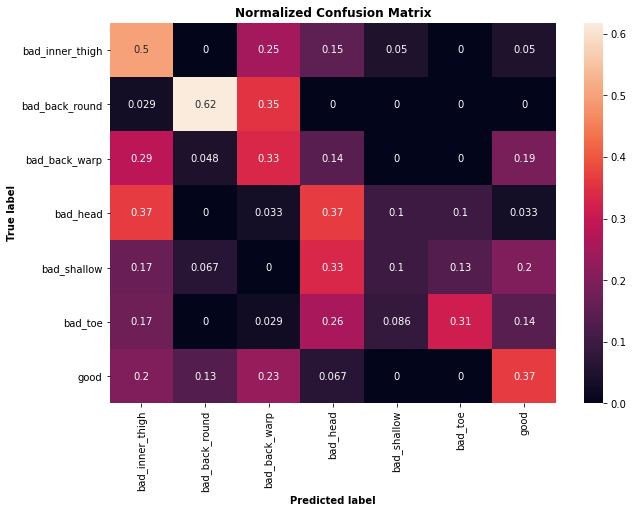


Accuracy: 0.37

Micro Precision: 0.37
Micro Recall: 0.37
Micro F1-score: 0.37

Macro Precision: 0.40
Macro Recall: 0.37
Macro F1-score: 0.36

Weighted Precision: 0.43
Weighted Recall: 0.37
Weighted F1-score: 0.37

Classification Report

                 precision    recall  f1-score   support

bad_inner_thigh       0.22      0.50      0.31        20
 bad_back_round       0.75      0.62      0.68        34
  bad_back_warp       0.21      0.33      0.26        21
       bad_head       0.29      0.37      0.32        30
    bad_shallow       0.30      0.10      0.15        30
        bad_toe       0.61      0.31      0.42        35
           good       0.39      0.37      0.38        30

       accuracy                           0.37       200
      macro avg       0.40      0.37      0.36       200
   weighted avg       0.43      0.37      0.37       200

Cohen Kappa Statistic



0.270516717325228

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
#Note: good source on the methods below: 
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#prelim results

#find model predictions
predictions = model.predict(test_dset)
y_pred = np.argmax(predictions, axis=1) #convert those predictions to labels

#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred, normalize = 'true') #true,pred
display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good']
df_cm = pd.DataFrame(cm, index = display_labels, columns = display_labels)
plt.figure(figsize=(10,7))
#sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size #,annot_kws={"size": 16}
plt.ylabel('True label', fontweight = 'bold')
plt.xlabel('Predicted label', fontweight = 'bold')
plt.title('Normalized Confusion Matrix', fontweight = 'bold')
plt.show()

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


print('\nClassification Report\n')
classification_rep = classification_report(y_test, y_pred, target_names=['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good'])
print(classification_rep)


#Cohen Kappa Statistic
print('Cohen Kappa Statistic\n')
cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)